In [5]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# Settings

In [6]:
# Calm which is present only in ravdess is ignored due to be too similiar to Neutral
# merging may cause imbalance
IGNORE_CALM = True

RANDOM_STATE = 44 

TRAIN_SIZE = 0.8
TEST_SIZE = 0.1
VAL_SIZE = 0.1


#raise error if sum of sizes is not 1
if abs(TRAIN_SIZE + TEST_SIZE + VAL_SIZE - 1) > 1e-6:
    raise ValueError(f"TRAIN_SIZE + TEST_SIZE + VAL_SIZE must be equal to 1, got: {TRAIN_SIZE + TEST_SIZE + VAL_SIZE}")



# Emotion labeling

In [7]:


#Using TESS and SAVEE labeling convention
emotion_dict={
    0: 'neutral',
    1: 'happy',
    2: 'sad',
    3: 'angry',
    4: 'fearful',
    5: 'disgusted',
    6: 'surprised'
}

# Data loading

In [8]:
def load_dataset(dataset, df, ignore_calm=True, remove_duplicates=True):
    """
    Load a dataset in the df, using TESS labeling.

    Supported datasets: RAVDESS, CREMA-D, TESS, SAVEE
    
    Args:
        dataset: name of the dataset, assuming is in data/Dataset/
        df (pd.DataFrame): emotion, file_path
     
        
    Returns:
        pd.DataFrame: update dataframe
    """
    dataset_path = 'data/Dataset/'+dataset
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"): 
                file_path = os.path.join(root, file)
                emotion = -1
                #RAVDESS
                if dataset == 'RAVDESS':
                    emotion = int(file.split("-")[2])-1 #to have 0-6 range
                    repetition = int(file.split("-")[5])
                    if remove_duplicates:
                        if repetition == 2:
                            continue
                            
                    if ignore_calm:
                        if emotion == 1:
                            continue
                        if emotion >= 2: 
                            emotion-=1
                #CREMA            
                elif dataset == 'CREMA-D':
                    part=file.split('_')
                    if part[2] == 'SAD':
                        emotion = 2
                    elif part[2] == 'ANG':
                        emotion = 3
                    elif part[2] == 'DIS':
                        emotion = 5
                    elif part[2] == 'FEA':
                        emotion = 4
                    elif part[2] == 'HAP':
                        emotion = 1
                    elif part[2] == 'NEU':
                        emotion = 0
                    else:
                        continue
                #TESS   
                elif dataset == 'TESS':
                    part=file.split('_')
                    part[2] = part[2].removesuffix('.wav')
                    if part[2] == 'angry':
                        emotion = 3
                    elif part[2] == 'disgust':
                        emotion = 5
                    elif part[2] == 'fear':
                        emotion = 4
                    elif part[2] == 'happy':
                        emotion = 1
                    elif part[2] == 'neutral':
                        emotion = 0
                    elif part[2] == 'ps':
                        emotion = 6
                    elif part[2] == 'sad':
                        emotion = 2
                #SAVEE        
                elif dataset == 'SAVEE':
                    ele = file.split('_')[1]
                    part = ele[:-6]
                    
                    if part == 'a':
                        emotion = 3
                    elif part == 'd':
                        emotion = 5
                    elif part == 'f':
                        emotion = 4
                    elif part == 'h':
                        emotion = 1
                    elif part == 'n':
                        emotion = 0
                    elif part == 'sa':
                        emotion = 6
                    elif part == 'su':
                        emotion = 2
                     
                    
                df.loc[len(df)] = [emotion, file_path]
    return df

def plot_class_distribution(y):
    #plot the class distribution
    plt.hist(y, bins=range(8), rwidth=0.8, align='left', color='skyblue')
    plt.xticks(range(8))
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

      emotion                                               path
0           3  data/Dataset/RAVDESS/Actor_16/03-01-05-01-02-0...
1           3  data/Dataset/RAVDESS/Actor_16/03-01-05-02-01-0...
2           5  data/Dataset/RAVDESS/Actor_16/03-01-07-01-01-0...
3           5  data/Dataset/RAVDESS/Actor_16/03-01-07-02-02-0...
4           6  data/Dataset/RAVDESS/Actor_16/03-01-08-02-02-0...
...       ...                                                ...
3899        3                      data/Dataset/SAVEE/JE_a01.wav
3900        3                      data/Dataset/SAVEE/JE_a15.wav
3901        0                      data/Dataset/SAVEE/DC_n22.wav
3902        2                     data/Dataset/SAVEE/DC_su04.wav
3903        2                     data/Dataset/SAVEE/DC_su10.wav

[3904 rows x 2 columns]


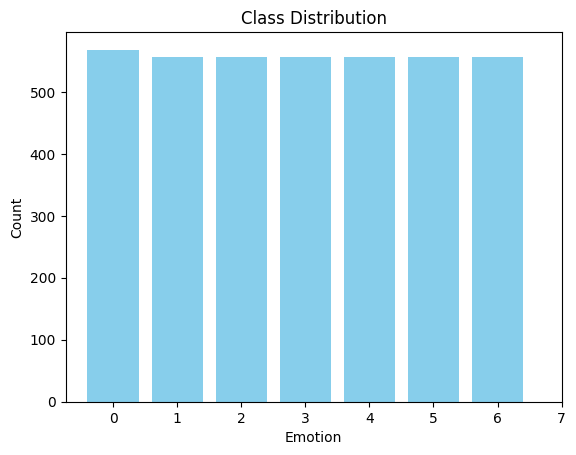

In [9]:
#Folder names
Ravdess = "RAVDESS"
Crema = "CREMA-D"
Tess = "TESS"
Savee = "SAVEE"

   
df = pd.DataFrame(columns=["emotion", "path"])

df = load_dataset(dataset=Ravdess, df = df, remove_duplicates=True,ignore_calm=IGNORE_CALM)
#df = load_dataset(dataset=Crema, df =df, ignore_calm=IGNORE_CALM)
df = load_dataset(dataset=Tess, df = df,ignore_calm=IGNORE_CALM)
df = load_dataset(dataset=Savee, df = df,ignore_calm=IGNORE_CALM)

print(df)

plot_class_distribution(df['emotion'])

# Train test split

In [10]:
train_indices, test_indices = train_test_split(
    df.index, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

train_indices, val_indices = train_test_split(
    train_indices, 
    test_size=VAL_SIZE/TRAIN_SIZE,  # 0.125* 0.8 = 10% 
    random_state=RANDOM_STATE
)


print("Total: ", len(df))
print("Train: ", len(train_indices))
print("Val: ", len(val_indices))
print("Test: ", len(test_indices))

Total:  3904
Train:  3073
Val:  440
Test:  391


# Save data

In [11]:
# save the indices
os.makedirs("data/path", exist_ok=True)
df.iloc[train_indices].to_csv("data/path/train.csv", index=False)
df.iloc[val_indices].to_csv("data/path/val.csv", index=False)
df.iloc[test_indices].to_csv("data/path/test.csv", index=False)
